# This notebook serves to train and benchmark models on a dataset annotated by label-studio 
This notebook is made to work on GPU, created on kaggle

In [1]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-_g41b8h1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-_g41b8h1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 017abbfa5f2c2a2afa045200c2af9ccf2fc6227f
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  2.0.0
detectron2: 0.6


In [3]:
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.model_zoo import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.structures import BoxMode
from io import BytesIO
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
import random
import PIL.Image
import requests
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

In the following cellule you have to choose the path for your dataset. and the classes you want to work on.  
the dataset has to contain a .json with the annotations and an "image" folder with all the images named after their id.

In [4]:
#MappingLabelStudio créer une instance à partir du fichier .json générer par LabelStudio
dataset_path = "/kaggle/input/galica"

json_file = dataset_path + "/galica/gallicaimages_set1.json"
image_dir =  dataset_path + "/image"

#list des categories sur lesquels on souhaite travailler
category_dict = {
  'tampon': 0,
  'écriture manuscrite': 1,
  'écriture typographique': 2,
  'photographie': 3,
  'estampe': 4
}

#choose the model you want to train
models = ["Detectron2", "LayoutParser"]
selected_model = models[1]

# Data preparation :  this section will do all the premilimnary work to adapt the data for the training

In [5]:
def update_image_sizes(json_file, image_dir, out):
    with open(json_file, encoding='utf-8') as f:
        data = json.load(f)

    for image in data['images']:
        image_id = image['id']
        image_path = image_dir + '/' + image_id + '.jpg'  # Chemin complet de l'image

        # Ouvrir l'image avec PIL
        img = PIL.Image.open(image_path)
        width, height = img.size

        # Mettre à jour les informations de taille dans le JSON
        image['width'] = width
        image['height'] = height

    # Écrire le JSON mis à jour dans un nouveau fichier
    with open(out, 'w') as outfile:
        json.dump(data, outfile)

    print("Mise à jour des tailles d'image terminée.")
    print("JSON mis à jour enregistré dans :", "gallica_dataset_file.json")
    
update_image_sizes(json_file, image_dir, "gallica_dataset_file.json")

Mise à jour des tailles d'image terminée.
JSON mis à jour enregistré dans : gallica_dataset_file.json


In [6]:
#replace this path with the destination path used in the call of update_image_sizes
gallica_json = "/kaggle/working/gallica_dataset_file.json"

In [7]:
import random

def get_my_dataset_dicts(json_file, category_dict, image_dir):
    """
        from gallica Label Studio to COCO dataset json
    """
    with open(json_file, encoding='utf-8') as f:
        data = json.load(f)

    dataset_dicts = []
    for idx, image in enumerate(data['images']):
        record = {}
        # Create file path from local directory and image id
        filename = os.path.join(image_dir, image['id'] + '.jpg')

        # Assign image properties
        record["file_name"] = filename
        record["height"] = image["height"] 
        record["width"] = image["width"]
        record["image_id"] = image['id']

        annotations = []
        # Assign annotations to image
        for ann in data["annotations"]:
            for result in ann["result"]:
                if ann["id"] == image["id"] and type(result["label"]) is not int and result["label"][0] in category_dict.keys():
                # Create a new dict for each annotation in the image
                    x = int(result['bbox']['x'] / 100.0 * image["width"])
                    y = int(result['bbox']['y'] / 100.0 * image["height"])
                    width = int(result['bbox']['width'] / 100.0 * image["width"])
                    height = int(result['bbox']['height'] / 100.0 * image["height"])
                    obj = {
                        "bbox": [x, y, width, height],
                        "bbox_mode": BoxMode.XYWH_ABS,  # as your bounding box coordinates are in absolute format
                        "category_id": category_dict[result["label"][0]],  # map your label name to its corresponding id
#                         "id": result["id"],
#                         "iscrowd": 0,
#                         "image_id":ann["id"],
                    }
                    annotations.append(obj)
        record["annotations"] = annotations
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:

def remove_all_datasets():
    registered_datasets = list(DatasetCatalog.list())
    for dataset_name in registered_datasets:
        DatasetCatalog.remove(dataset_name)
remove_all_datasets()

In [9]:
# PRINT DATASET

def print_coco_dataset(dataset):
    my_dataset_metadata = MetadataCatalog.get(dataset)

    # Get your dataset in Detectron2's format
    dataset_dicts = DatasetCatalog.get(dataset)

    for d in random.sample(dataset_dicts, 3):
        # Open the image file
        img = PIL.Image.open(d["file_name"])
        img = np.array(img)

        # Handle grayscale images:
        if len(img.shape) == 2:
            img = np.stack([img] * 3, axis=-1)

        # Create a visualizer instance
        visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_metadata, scale=0.5)

        # Draw the predictions on the image
        vis = visualizer.draw_dataset_dict(d)

        # Show the image using matplotlib
        plt.imshow(vis.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()


In [10]:
def split_data(json_file, category_dict, image_dir, split='train'):
    # Load json file
    """
        Divide original dataset in train , val , test
    """
    with open(json_file) as f:
        data = json.load(f)

    classes_count = np.zeros(len(category_dict))
    # Convert to Detectron2 format
    dataset_dicts = get_my_dataset_dicts(json_file, category_dict, image_dir)
    print(len(dataset_dicts))
    
    #get total number of each classes
    for data in dataset_dicts:        
        for annotation in data["annotations"]:
            classes_count[annotation["category_id"]] += 1
    
    data_train = []
    data_val = []
    data_test = []
    data_lost = []
    nb_image = 0
    count = np.zeros(len(category_dict))
    classes_count_sorted = np.argsort(classes_count)
    for data in dataset_dicts:
        isLost = True
        for annotation in data["annotations"]:
            v = False
            for i in range(len(category_dict)):
                if count[annotation["category_id"]] < classes_count[classes_count_sorted[i]]*0.83:
                    data_train.append(data)
                    for annotation in data["annotations"]:
                        count[annotation["category_id"]] += 1
                    nb_image+=1
                    v=True
                    break
                elif count[annotation["category_id"]] < classes_count[classes_count_sorted[i]]*0.95:
                    data_val.append(data)
                    for annotation in data["annotations"]:
                        count[annotation["category_id"]] += 1
                    nb_image+=1
                    v=True
                    break
                elif count[annotation["category_id"]] < classes_count[classes_count_sorted[i]]:
                    data_test.append(data)
                    for annotation in data["annotations"]:
                        count[annotation["category_id"]] += 1
                    nb_image+=1
                    v=True
                    break
            if v:
                isLost = False
                break
        if isLost:
            data_lost.append(data)
            
    #append lost data to test data
    for data in data_lost:
        data_test.append(data)
                        
    print("count: ", count)
    print("classes_count: ", classes_count)
    print("nb_image: ", nb_image)
    print("data_lost", len(data_lost))
    
    return data_train, data_val, data_test
    
datasets = split_data(gallica_json, category_dict, image_dir)

2738
count:  [ 650. 4410. 5598. 1557. 1038.]
classes_count:  [ 650. 4410. 5598. 1557. 1038.]
nb_image:  2707
data_lost 31


This cellule will copy all the test images to a directory, don't forget to replace the destination directory with your own

In [11]:
import os
import shutil

test_images = []
for i in range(len(datasets[2])):
    test_images.append(datasets[2][i]["image_id"])


# Define source and destination directories
image_dir = dataset_path + "/image"  # Your source directory
destination_dir = "/kaggle/working/test_images"  # Replace with your destination directory

# Create the destination directory if it doesn't exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Iterate through the list of image filenames and copy them to the destination directory
for image_filename in test_images:
    # Add the .jpg extension to the filenames
    image_filename_with_extension = image_filename + ".jpg"
    
    source_path = os.path.join(image_dir, image_filename_with_extension)
    destination_path = os.path.join(destination_dir, image_filename_with_extension)
    
    try:
        shutil.copy(source_path, destination_path)
        print(f"Successfully copied {image_filename} to {destination_dir}")
    except FileNotFoundError:
        print(f"File not found: {image_filename}")
    except FileExistsError:
        print(f"File already exists in the destination directory: {image_filename}")

Successfully copied 13a8a57e-3017-497f-a3f3-0dd15abdf70f to /kaggle/working/test_images
Successfully copied 6d1b71b9-0477-43d3-b997-050cf3fd79e6 to /kaggle/working/test_images
Successfully copied ca7820d2-679a-4bb2-82b8-a2d5c9c9b2e4 to /kaggle/working/test_images
Successfully copied de439109-a4bf-4b54-93a1-4a7381712bd4 to /kaggle/working/test_images
Successfully copied c7452192-fc03-4614-858e-156a6254a4e3 to /kaggle/working/test_images
Successfully copied d847c2e6-23ab-463b-91f8-c774da7122ab to /kaggle/working/test_images
Successfully copied 41cd740c-935f-4213-9928-c719ae82dd11 to /kaggle/working/test_images
Successfully copied 2de45329-04f6-494d-975a-71302836fe82 to /kaggle/working/test_images
Successfully copied 62fff69c-f976-4d50-96d8-856cc50f99a4 to /kaggle/working/test_images
Successfully copied 156d1606-69dc-413c-b797-39ce1b2b0f85 to /kaggle/working/test_images
Successfully copied 67a07b78-f7cd-4768-9b12-b65dbc4a396c to /kaggle/working/test_images
Successfully copied fb25a47c-ea6

In [13]:
def get_dataset_dicts_split(datasets, split='train'):
    # Load json file
    """
        Divide original dataset in train , val , test
    """
    
    # Shuffle data
    random.shuffle(datasets[0])
    random.shuffle(datasets[1])
    random.shuffle(datasets[2])

    if split == 'train':
        return datasets[0]
    elif split == 'val':
        return datasets[1]
    elif split == 'test':
        return datasets[2]

In [14]:
remove_all_datasets()

for d in ["train", "val", "test"]:
    DatasetCatalog.register("my_dataset_" + d, lambda d=d: get_dataset_dicts_split(datasets, d))
    MetadataCatalog.get("my_dataset_" + d).set(thing_classes=list(category_dict.keys()))

# Data visualization  
Displaying a few images from the validation set

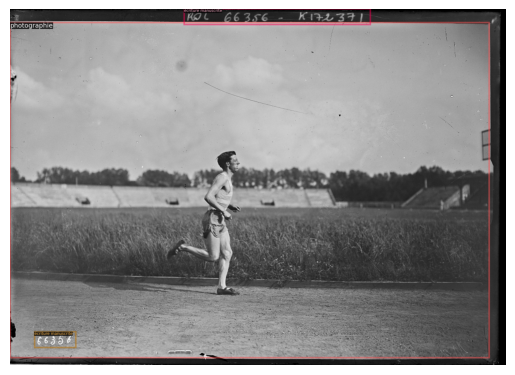

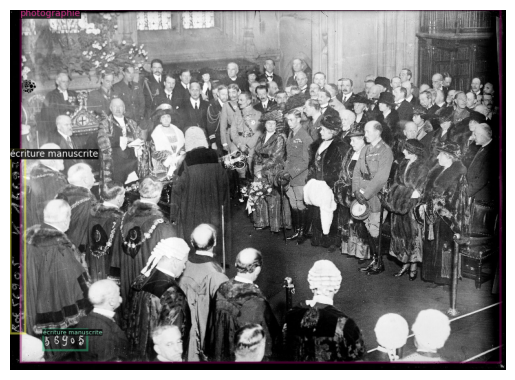

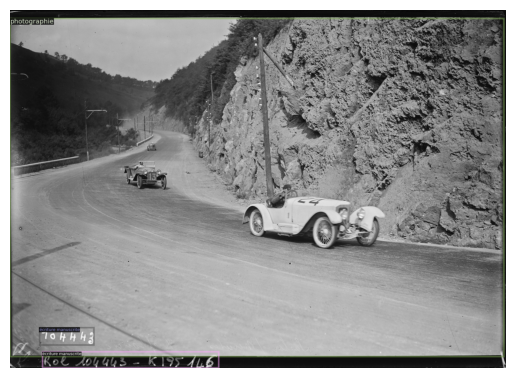

In [15]:
print_coco_dataset("my_dataset_val")

# This is the training section with default values  
In the below cellule you can modify with your own training parameters

In [16]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

In [17]:
modeldata_path = "/kaggle/input/modeldata/"

cfg = get_cfg()

if  selected_model == "Detectron2":
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

elif selected_model == "LayoutParser":
    # Specify the model to use
    cfg.merge_from_file(modeldata_path + "config.yml")
    cfg.MODEL.WEIGHTS = modeldata_path + "model_final.pth"
    
else :
    raise ValueError("Invalid model selected!")

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 1000 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(category_dict)

We start the training with selected model

In [18]:
import time

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)

# Measure the training time
start_time = time.time()
trainer.train()
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Training time: {:.4f} seconds".format(elapsed_time))

/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init

Training time: 418.2935 seconds


We can visualize the performances of the model with the Detectron2 evaluator

In [19]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset, COCOPanopticEvaluator
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog

# Get the metadata for your dataset
my_dataset_metadata = MetadataCatalog.get("my_dataset_val")

# Create an evaluator for the validation set
evaluator = COCOEvaluator("my_dataset_val", output_dir="./output")

# Create a test data loader
test_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Perform inference on the validation set
try:
    results = inference_on_dataset(trainer.model, test_loader, evaluator)
except Exception as e:
    # Print the error message
    print("Error:", str(e))

Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.416
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.638
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.423
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.409
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.498
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.502
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.106
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.150
 Average Recall     (AR) @[ IoU=0.50:0.

In [20]:
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultPredictor


#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8  # set the testing threshold for this model
#Pass the validation dataset
cfg.DATASETS.TEST = ("my_dataset_val", )

predictor = DefaultPredictor(cfg)

We save the model under my_model.pth

In [21]:
from detectron2.checkpoint import DetectionCheckpointer, Checkpointer

checkpointer = DetectionCheckpointer(trainer.model, save_dir=cfg.OUTPUT_DIR)
checkpointer.save("my_model")

# This section allow you to visualize the predictions of your model on images  
This cellule will save a few predictions on the test dataset in a directory

Groundtruth on the left and Predictions on the right


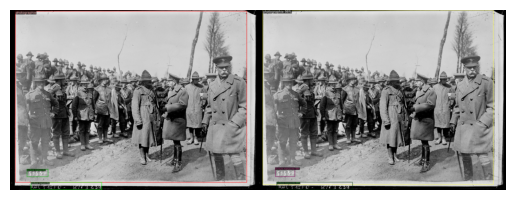

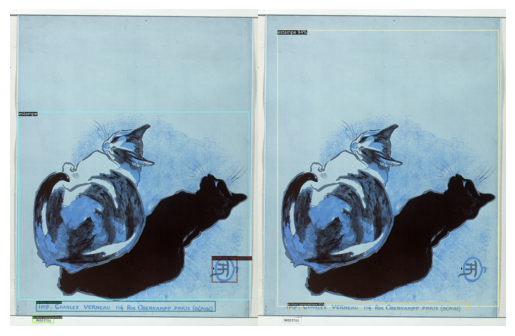

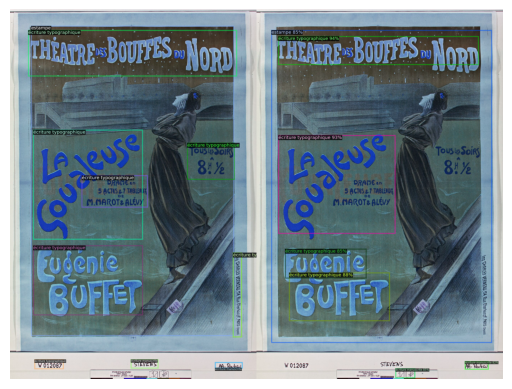

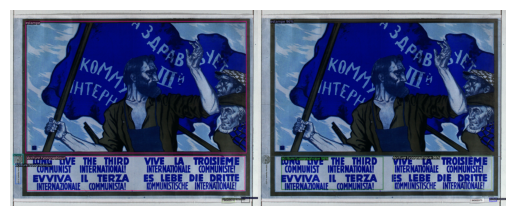

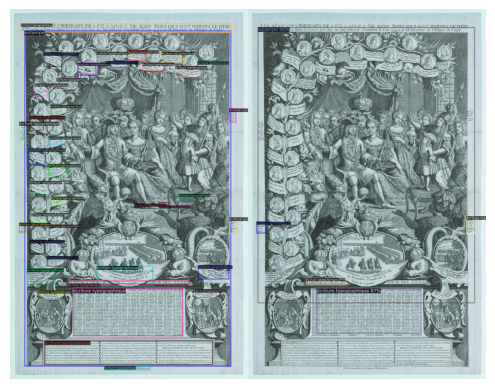

In [40]:
predictions_path = "/kaggle/working/predictions" # choose your path
number_of_predictions = 5 #choose the number of predictions you want to save

dataset_dicts = DatasetCatalog.get("my_dataset_test")
metadata = MetadataCatalog.get("my_dataset_test")

print("Groundtruth on the left and Predictions on the right")
n_pred = 0
for d in dataset_dicts:
    im = cv2.imread(d["file_name"])

    # Make predictions
    outputs = predictor(im)

    # Visualize both ground truth and predictions
    visualizer_pred = Visualizer(
        im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE
    )
    visualizer_gt = Visualizer(
        im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE
    )


    # Draw ground truth bounding boxes
    gt_visualized = visualizer_gt.draw_dataset_dict(d)

    # Draw instance predictions
    predictions_visualized = visualizer_pred.draw_instance_predictions(outputs["instances"].to("cpu"))


    # Combine the images horizontally
    final_image = np.concatenate((gt_visualized.get_image()[:, :, ::-1], predictions_visualized.get_image()[:, :, ::-1]), axis=1)
    
    # Assuming you have final_image generated
    final_image_bgr = final_image[:, :, ::-1]  # Convert to BGR format

    if not os.path.exists(predictions_path):
        os.makedirs(predictions_path)
    
    # Save the image to a file (e.g., final_image.png)
    cv2.imwrite(predictions_path+d["image_id"]+'.png', final_image_bgr)

    # Show the combined image using matplotlib
    plt.imshow(final_image)
    plt.axis('off')
    plt.show()
    n_pred+=1
    if n_pred >= number_of_predictions:
        break

# This section is the evaluation of the model performances with coco panoptic

COCO Panoptic Metric Explanation

The COCO Panoptic Metric is a widely used evaluation measure in computer vision, specifically designed to assess the performance of algorithms and models in the context of panoptic segmentation. Panoptic segmentation is a task that unifies the understanding of both stuff (e.g., road, sky) and things (e.g., cars, people) in a scene, making it a comprehensive way to analyze and interpret images and videos.

The COCO Panoptic Metric takes into account the quality of segmentation, ensuring that objects are correctly delineated, and the understanding of the overall scene context, providing a holistic assessment of the model's performance in scene understanding.

The evaluation is typically performed by comparing the model's output to ground truth annotations. The metric is expressed as a combination of the average "thing" and "stuff" segmentation accuracies, along with the "panoptic quality," which summarizes the model's ability to capture the complete scene.  

Here you only need to run all the cells without changing anything and a graph will show the results per class at the end.

This code cell enables you to visualize the model predictions on a selected directory of images. This is particularly useful for assessing the model's performance on tricky images or testing it against edge cases.

In [24]:
def predict_directory(path):
    for file_name in os.listdir(path):
        # Read the image
        file_path = os.path.join(path, file_name)
        im = cv2.imread(file_path)

        # Measure the prediction time
        start_time = time.time()
        outputs = predictor(im)
        end_time = time.time()
        
        # Calculate the elapsed time
        elapsed_time = end_time - start_time

        print("Inference time: {:.4f} seconds, shape of {}".format(elapsed_time, im.shape))
        
        # Extract the instance masks and their associated classes
        instances = outputs["instances"].to("cpu")
        #instance_masks = instances.pred_masks.numpy()
        print(instances.pred_boxes.tensor.tolist())
        print(instances.pred_classes.tolist())

        # Visualize the predictions
        v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        # Display the image
        plt.imshow(v.get_image()[:, :, ::-1])
        plt.axis('off')
        plt.show()
        
#predict_directory("your/path")

In [25]:
!python -m pip install coco-pano-ext-demo

Creation of a binary mask for each class with the groundtruth and the prediction on the test images

In [26]:
img_size = (400,400)

def create_mask_with_json(data, width, height):
    masks = [np.zeros(img_size, dtype=np.uint8) for x in range(len(category_dict))]
    for annotation in data["annotations"]:
        # Convert annotation units to pixel values
        x = int(annotation['bbox'][0])
        y = int(annotation['bbox'][1])
        x2 = int(annotation['bbox'][2])
        y2 = int(annotation['bbox'][3])
        
        # Scale the coordinates to match the mask size
        x_scaled = int(x * img_size[1] / width)      # New x-coordinate after scaling
        y_scaled = int(y * img_size[0] / height)     # New y-coordinate after scaling
        width_scaled = int(x2 * img_size[1] / width)    # New width after scaling
        height_scaled = int(y2 * img_size[0] / height)  # New height after scaling
        

        # Assign the corresponding label value to the pixels within the scaled bounding box
        masks[annotation["category_id"]][y_scaled:y_scaled+height_scaled, x_scaled:x_scaled+width_scaled] = 1
        
    return np.array(masks)

def create_mask_with_prediction(boxes, classes, width, height):
    masks = [np.zeros(img_size, dtype=np.uint8) for x in range(len(category_dict))]
    for i in range(len(boxes)):
        # Convert annotation units to pixel values
        x = int(boxes[i][0])
        y = int(boxes[i][1])
        x2 = int(boxes[i][2])
        y2 = int(boxes[i][3])

        # Scale the coordinates to match the mask size
        x_scaled = int(x * img_size[1] / width)      # New x-coordinate after scaling
        y_scaled = int(y * img_size[0] / height)     # New y-coordinate after scaling
        width_scaled = int(x2 * img_size[1] / width)    # New width after scaling
        height_scaled = int(y2 * img_size[0] / height)  # New height after scaling

        # Assign the corresponding label value to the pixels within the scaled bounding box
        masks[classes[i]][y_scaled:height_scaled, x_scaled:width_scaled] = 1
    
    return np.array(masks)

def predict_image(path):
    # Read the image
    im = cv2.imread(path)

    # Perform prediction
    outputs = predictor(im)

    # Extract the instance masks and their associated classes
    instances = outputs["instances"].to("cpu")

    return (instances.pred_boxes.tensor.tolist(),instances.pred_classes.tolist()) 
        
    
groundtruth = []
predictions = []
for data in dataset_dicts:
    groundtruth.append(create_mask_with_json(data, data["width"], data["height"]))
    prediction = predict_image(data["file_name"])
    predictions.append(create_mask_with_prediction(prediction[0], prediction[1], data["width"], data["height"]))

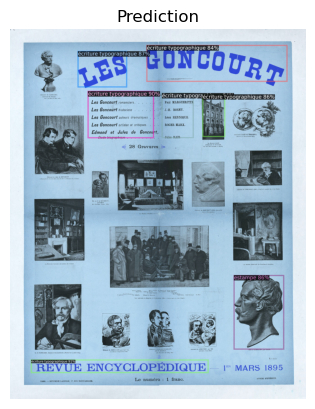

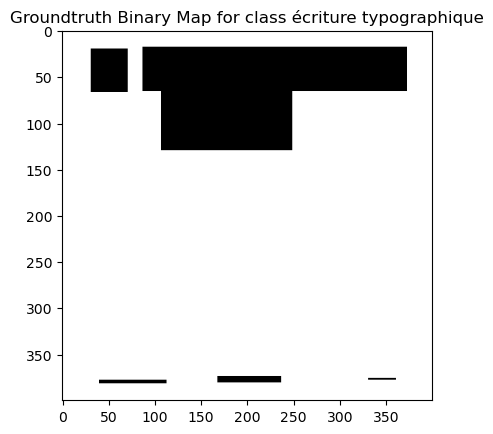

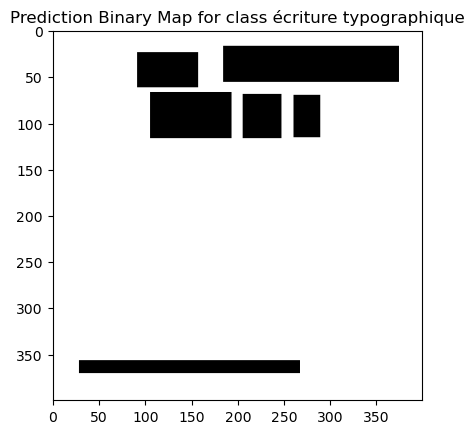

In [36]:
#This function allow you to visualize the binary masks created before, 
#the first argument is the index of the image in the test dataset and 
#the second argument is the index of the class in category_dict
def show_pred(n, class_predicted=1):
    truth = []
    for annotation in dataset_dicts[n]["annotations"]:
        l = annotation['bbox'].copy()
        l[2] += l[0]
        l[3] += l[1]
        truth.append(l)
        
    # Read the image
    im = cv2.imread(dataset_dicts[n]["file_name"])

    # Perform prediction
    outputs = predictor(im)

    # Extract the instance masks and their associated classes
    instances = outputs["instances"].to("cpu")

    # Visualize the predictions
    v = Visualizer(im[:, :, ::-1], metadata=metadata, scale=0.8, instance_mode=ColorMode.IMAGE)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Display the image
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.title('Prediction')
    plt.axis('off')
    plt.show()
    
    plt.imshow(groundtruth[n][class_predicted], cmap='binary')  # 'binary' colormap for black and white
    plt.title('Groundtruth Binary Map for class '+ list(category_dict.keys())[class_predicted])
    plt.show()

    plt.imshow(predictions[n][class_predicted], cmap='binary')  # 'binary' colormap for black and white
    plt.title('Prediction Binary Map for class '+ list(category_dict.keys())[class_predicted])
    plt.show()

show_pred(0, 2)

Here we have the pipeline evaluation with coco panoptic using the binary masks

In [28]:
from coco_pano_ext_demo import COCO_plot, COCO
from coco_pano_ext_demo.coco import _compute_labelmap, _compute_iou
from coco_pano_ext_demo.iou import compute_matching_scores

In [29]:
def compute_matching_weights(target_binary_image, pred_binary_image) -> tuple[list[float], list[float]]:
    # computes IoUs
    wtp, wpt = 0,0
    if np.all(pred_binary_image==0):
        wtp, wpt = _compute_iou(T, T)
    elif np.all(target_binary_image==0):
        wtp, wpt = _compute_iou(P, P)
    else:
        wtp, wpt = _compute_iou(T, P)
    # remove background components
    wtp, wpt = wtp[1:], wpt[1:]
    return wtp, wpt

In [30]:
from typing import Iterable
import pandas as pd
from tqdm import tqdm
def compute_pq_score_list_single_class(targets: Iterable[np.ndarray], predictions: Iterable[np.ndarray], class_name) -> tuple[float, float, float, pd.DataFrame]:
    # Init global accumulators
    W_TtoP_global = []
    W_PtoT_global = []
    # loop over predictions (single class, TODO repeat for each class)
    for T0, P0 in tqdm(zip(targets, predictions), desc="evaluating class " + class_name, total=len(targets)):
        # Compute pairwise matching scores, exluding background
        wtp, wpt = compute_matching_weights(T0, P0)
        # Update global matching lists
        W_TtoP_global.extend(wtp.tolist())
        W_PtoT_global.extend(wpt.tolist())
    # report final score
    pairing_threshold = 0.5
    df = compute_matching_scores(np.array(W_TtoP_global), np.array(W_PtoT_global), pairing_threshold)
    COCO_SQ = df["IoU"].mean() if len(df) > 0 else 0
    COCO_RQ = df["F-score"].iloc[0] if len(df) > 0 else 0
    COCO_PQ = COCO_SQ * COCO_RQ
    
    return COCO_PQ, COCO_RQ, COCO_SQ, df

In [31]:
#get the average iou of the predictions
scores_per_class = np.zeros(len(category_dict))

for i in range(len(category_dict)):
    T = np.array(groundtruth)[:,i]
    P = np.array(predictions)[:,i]
    scores_per_class[i], COCO_RQ, COCO_SQ, df = compute_pq_score_list_single_class(T, P, list(category_dict.keys())[i])

scores_per_class

evaluating class estampe: 100%|██████████| 261/261 [02:02<00:00,  2.13it/s]


array([0.86206897, 0.44444444, 0.7686647 , 0.94069072, 0.85262857])

Finally we show the performance of our model

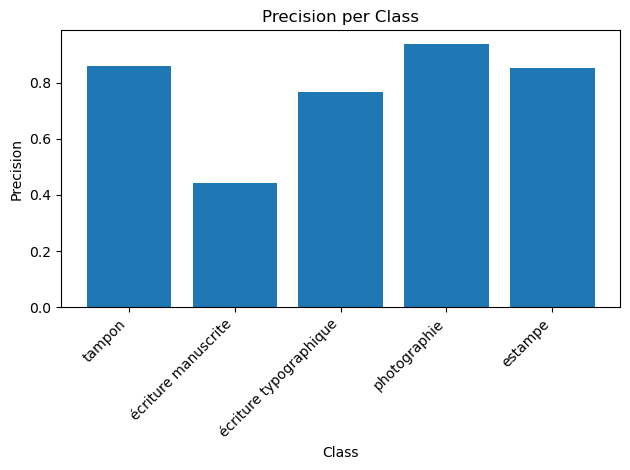

                    Class  Precision
0                  tampon   0.862069
1     écriture manuscrite   0.444444
2  écriture typographique   0.768665
3            photographie   0.940691
4                 estampe   0.852629


In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame
df = pd.DataFrame({'Class': list(category_dict.keys()), 'Precision': scores_per_class})

# Remove rows with NaN precision scores
df = df.dropna(subset=['Precision'])

# Create a histogram
plt.bar(df['Class'], df['Precision'])
plt.xlabel('Class')
plt.ylabel('Precision')
plt.title('Precision per Class')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility

# Show the plot
plt.tight_layout()
plt.show()
print(df)